In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,cast,Date

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\nitub\AppData\Local\Temp\ipykernel_17808\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
class_names = Base.classes.keys()
print(class_names)

['measurement', 'station']


In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
date_obj = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Convert back to string in the desired format (MM/DD/YYYY)
formatted_date = date_obj.strftime('%m/%d/%Y')

print(formatted_date) 

08/23/2017


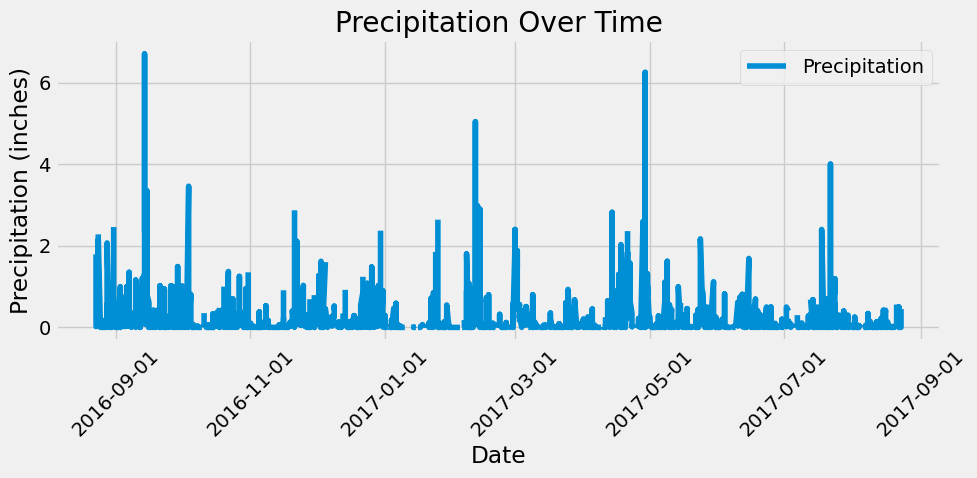

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results without using a variable
precipitation_data = session.query(
    measurement.date,
    measurement.prcp
).filter(
    measurement.date >= func.date(session.query(func.max(measurement.date)).scalar(), '-1 year')  # Use max date - 1 year
).all()
# Save the query results as a Pandas DataFrame
df_precipitation = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Convert the 'date' column to datetime format
df_precipitation['date'] = pd.to_datetime(df_precipitation['date'])

# Sort the DataFrame by date
df_precipitation.sort_values(by='date', inplace=True)

# Plot the data
plt.figure(figsize=(10,5))
plt.plot(df_precipitation['date'], df_precipitation['prcp'],label='Precipitation')
plt.title('Precipitation Over Time')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format to show full date
plt.xticks(rotation=45)
plt.legend(loc="upper right") 
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df_precipitation['prcp'].describe()

# Print the summary statistics
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = (

    session.query(measurement.station, func.count(measurement.station).label('count'))
    .group_by(measurement.station)
    .order_by(func.count(measurement.station).desc())
    .all()
)

# Print the results
for record in most_active_stations:
    print(record)


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'  # Replace with the actual station ID from your previous query

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = (
    session.query(
        func.min(measurement.tobs).label('min_temp'),
        func.max(measurement.tobs).label('max_temp'),
        func.avg(measurement.tobs).label('avg_temp')
    )
    .filter(measurement.station == most_active_station_id)
    .all()
)
# Print the results
for record in temperature_stats:
    print(record)

(54.0, 85.0, 71.66378066378067)


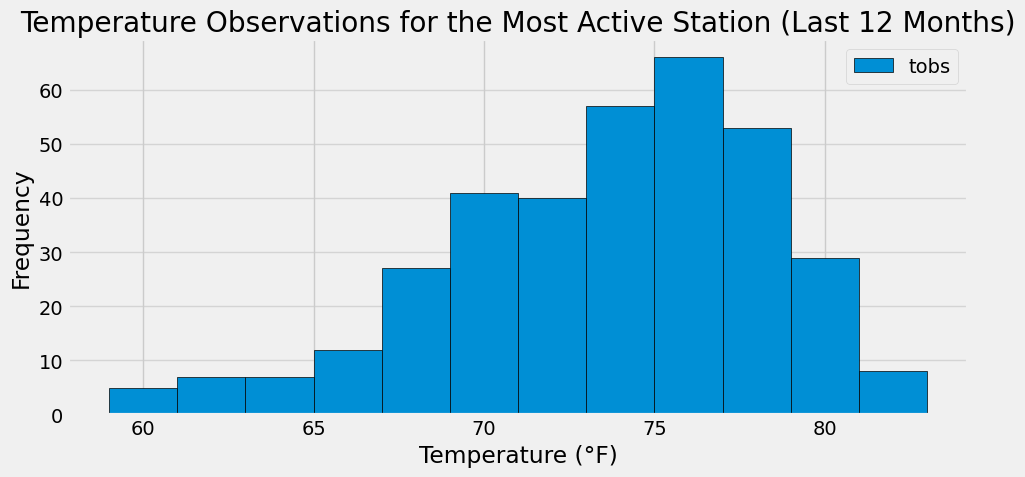

In [15]:

# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(measurement.tobs)
    .filter(
        measurement.station == most_active_station_id,
        measurement.date >= (
            session.query(func.date(func.max(measurement.date), '-1 year')).scalar()
        )
    )
).all()


# Convert the query results to a Pandas DataFrame
df_temperature = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(df_temperature['tobs'], bins=12, edgecolor='black',label='tobs')
plt.title('Temperature Observations for the Most Active Station (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.legend()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()